 <h3>Univariate Time Series Prediction - LSTM RNN </h3>
on Google stock closing value data

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

# generate same random-numbers again
np.random.seed(40)


symbol          object
date            object
close          float64
high           float64
low            float64
open           float64
volume           int64
adjClose       float64
adjHigh        float64
adjLow         float64
adjOpen        float64
adjVolume        int64
divCash        float64
splitFactor    float64
dtype: object


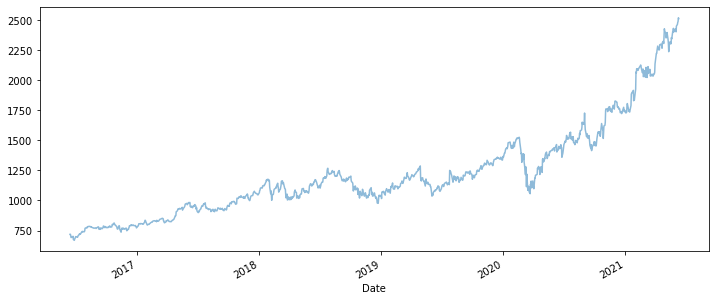

In [31]:
# =============================================================================
# Step 1 - Get the data
# =============================================================================

df=pd.read_csv('D:/Study/VII sem/DL/dl_yt/other_files/Google_stock.csv')

# Checking if the data has any discrepancies 
print(df.dtypes)
# print(df['date'].isnull().sum())
#print(len(df['date'].unique())) #We have data for 1258 days

# Converting the date from object to datetime
df['Date']=pd.to_datetime(df['date'])
df.set_index('Date',inplace = True)
df['close'].plot(figsize=(12,5),alpha=0.5)

df_new = df.reset_index()['close']
#df_new.head()


In [43]:
# =============================================================================
# Step 2 - Pre process
# =============================================================================

#Transforming the values
scaler = MinMaxScaler(feature_range=(0,1))
df_new= scaler.fit_transform(np.array(df_new).reshape(-1,1))

#Splitting into train and test
size = int(len(df_new)*0.66)
data_train,data_test = df_new[0:size,:],df_new[size:,:1] # 830 , 428

#Time series data from 1D 
def to_timeseries(data , time_step=1):
    data_X=[]
    data_y=[]
    for i in range(len(data)-time_step-1):
        data_X.append(data[i:i+time_step,0])
        data_y.append(data[i+time_step,0])
    return np.array(data_X),np.array(data_y)
    
#Converting 1D data_train/test to time series
time_step=200 
X_train,y_train= to_timeseries(data_train,time_step)
X_test,y_test= to_timeseries(data_test,time_step)

#Reshpe data as per LSTM reqm [samples, input_shape=(time steps, features)]
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_test =  np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [44]:
# =============================================================================
# Step 3 - LSTM model
# =============================================================================
model = Sequential()
model.add(LSTM(32, input_shape=(time_step,1),return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1))

#Compile
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 200, 32)           4352      
                                                                 
 lstm_3 (LSTM)               (None, 16)                3136      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 7,505
Trainable params: 7,505
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.fit(X_train,y_train,validation_data=(X_test,y_test), epochs=50, batch_size= 64, verbose=2)

Epoch 1/50
10/10 - 5s - loss: 0.0234 - val_loss: 0.0586 - 5s/epoch - 496ms/step
Epoch 2/50
10/10 - 1s - loss: 0.0031 - val_loss: 0.0425 - 1s/epoch - 129ms/step
Epoch 3/50
10/10 - 1s - loss: 0.0012 - val_loss: 0.0799 - 1s/epoch - 123ms/step
Epoch 4/50
10/10 - 1s - loss: 0.0011 - val_loss: 0.0498 - 1s/epoch - 120ms/step
Epoch 5/50
10/10 - 1s - loss: 8.9129e-04 - val_loss: 0.0460 - 1s/epoch - 119ms/step
Epoch 6/50
10/10 - 1s - loss: 7.2432e-04 - val_loss: 0.0498 - 1s/epoch - 126ms/step
Epoch 7/50
10/10 - 1s - loss: 6.2688e-04 - val_loss: 0.0363 - 1s/epoch - 116ms/step
Epoch 8/50
10/10 - 1s - loss: 5.7630e-04 - val_loss: 0.0332 - 1s/epoch - 121ms/step
Epoch 9/50
10/10 - 1s - loss: 5.1421e-04 - val_loss: 0.0276 - 1s/epoch - 139ms/step
Epoch 10/50
10/10 - 1s - loss: 4.6120e-04 - val_loss: 0.0221 - 1s/epoch - 149ms/step
Epoch 11/50
10/10 - 2s - loss: 4.2216e-04 - val_loss: 0.0183 - 2s/epoch - 175ms/step
Epoch 12/50
10/10 - 2s - loss: 3.9248e-04 - val_loss: 0.0141 - 2s/epoch - 166ms/step
Epoch

In [46]:
# =============================================================================
# Step 4 - Prediction
# =============================================================================
#Making predictions
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

import math
#Calc RMSE and comparing it with ARIMA's
print("RMSE train = ",math.sqrt(mean_squared_error(y_train,train_predict)))
print("RMSE test = ",math.sqrt(mean_squared_error(y_test,test_predict)))

RMSE train =  0.017277201536782326
RMSE test =  0.05750429896682036


In [47]:
# =============================================================================
# Step 5 - Plotting
# =============================================================================

#Inverse transforming to plot
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

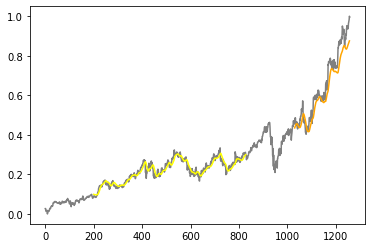

In [58]:
#Plotting 
look_back=200

# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_new)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(df_new)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_new)-1, :] = test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(df_new), color="grey")
plt.plot(trainPredictPlot,color='yellow')
plt.plot(testPredictPlot,color='orange')

plt.show()